<a href="https://colab.research.google.com/github/anhvt00/PIPR/blob/master/models/PIPR_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook use for tunning model using embeddings file and language model embedder

### Check GPU hardware

In [ ]:
!nvidia-smi

Tue Feb  1 04:09:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download embedding files

In [ ]:
# Download file seq2tensor.py for converting protein sequences to tensors
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/seq2tensor.py

# Download file ac5_aph.txt for ac5_aph embedding 
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/ac5_aph.txt

### Download interaction pairs and dictionary files
# Download dictionary file (id: sequence)
# Download dictionary file (id: sequence)
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Tunning-architecture-dataset/yeast_pairs.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_pairs.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/H.pylori/hp_pairs.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/H.pylori/hp_dict.tsv
# Download pairs of proteins with labels file
# !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Tunning-architecture-dataset/yeast_dictionary.tsv
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/data/Golden-tunning-datasets/S.cerevisae/yeast_dictionary.tsv

--2022-02-01 04:09:19--  https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/seq2tensor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1104 (1.1K) [text/plain]
Saving to: ‘seq2tensor.py’

seq2tensor.py       100%[===================>]   1.08K  --.-KB/s    in 0s      

2022-02-01 04:09:19 (37.9 MB/s) - ‘seq2tensor.py’ saved [1104/1104]

--2022-02-01 04:09:19--  https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/ac5_aph.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2335 (2.3K) [text/plain]
Saving

### Import libraries 

In [ ]:
# Libraries for system and debug
import sys
import pdb
import os
from datetime import datetime

# Class for converting sequences to tensors
from seq2tensor import s2t


# Libraries for neural network training
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Input, Conv1D, Conv2D
from tensorflow.keras.layers import Add, Flatten, subtract, multiply, concatenate
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras import mixed_precision
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Import accessory modules
import numpy as np
import h5py
import gc
from tqdm import tqdm
import math

# For tensorboard extension
!pip install -U tensorboard_plugin_profile

### Set CUDA environment variables

In [ ]:
### Setting RAM GPU for training growth 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)





# ============================================
# Optimisation Flags - Do not remove
# ============================================

# Disables caching (when set to 1) or enables caching (when set to 0) for just-in-time-compilation. When disabled,
# no binary code is added to or retrieved from the cache.
os.environ['CUDA_CACHE_DISABLE'] = '0' # orig is 0

# When set to 1, forces the device driver to ignore any binary code embedded in an application 
# (see Application Compatibility) and to just-in-time compile embedded PTX code instead.
# If a kernel does not have embedded PTX code, it will fail to load. This environment variable can be used to
# validate that PTX code is embedded in an application and that its just-in-time compilation works as expected to guarantee application 
# forward compatibility with future architectures.
os.environ['CUDA_FORCE_PTX_JIT'] = '1'# no orig


os.environ['HOROVOD_GPU_ALLREDUCE'] = 'NCCL'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT']='1'

os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'

os.environ['TF_ADJUST_HUE_FUSED'] = '1'
os.environ['TF_ADJUST_SATURATION_FUSED'] = '1'
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

os.environ['TF_SYNC_ON_FINISH'] = '0'
os.environ['TF_AUTOTUNE_THRESHOLD'] = '2'
os.environ['TF_DISABLE_NVTX_RANGES'] = '1'
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"



# =================================================
# mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs


### Hyperparameter set by default



In [ ]:
# Default hyperparameters
CONV_HIDDEN_DIM = 50
RNN_HIDDEN = 50
N_EPOCHS = 40
HIDDEN_DIM=50
BATCH_SIZE = 32
DTYPE='float16'
LEARNING_RATE=.001
EPSILON=1e-6
adam = Adam(learning_rate=LEARNING_RATE, amsgrad=True, epsilon=EPSILON)
MAX_DATASET_SIZE = 11187
DATASET_SIZE = MAX_DATASET_SIZE
KERNEL_SIZE = 3
POOLING_KERNEL = 3
seq_size=2000
dim = 1024
# 1 for language model embedding
flags_embedding = 0
# 1 for loading from drive
available_data = 0



### Load the embeddings from drive

In [ ]:
if available_data == 1:
    from google.colab import drive
    drive.mount('/content/drive')

    seq_tensor = np.load('/content/drive/MyDrive/seq_tensor.npy', allow_pickle=True)
    # Load contextual embeddings here
    # seq_tensor = np.load('/content/drive/MyDrive/Embeddings_Guo/15_amino_Word2VecEmbedder.npy', allow_pickle=True)

    class_labels = np.load('/content/drive/MyDrive/class_labels.npy', allow_pickle=True)
    seq_index1 = np.load('/content/drive/MyDrive/seq_index1.npy', allow_pickle=True)
    seq_index2 = np.load('/content/drive/MyDrive/seq_index2.npy', allow_pickle=True)
    # seq_tensor_physicochemical= np.load('/content/drive/MyDrive/physicochemical.npy', allow_pickle=True)

In [ ]:
# seq_tensor= tf.keras.preprocessing.sequence.pad_sequences(seq_tensor,  padding='post', dtype='float16', truncating='post', maxlen=seq_size)
seq_tensor= tf.keras.preprocessing.sequence.pad_sequences(seq_tensor,  padding='post', dtype='float16', truncating='post', maxlen=2000)

NameError: ignored

In [ ]:
seq_tensor.shape

In [ ]:
# seq_tensor_list = []
# for i in range(len(seq_tensor)):
#   seq_tensor_list.append(seq_tensor[i].astype('float16'))


In [ ]:
# seq_tensor = seq_tensor_list

In [ ]:
# seq_tensor_list = 0

In [ ]:
# seq_tensor[0]

In [ ]:
# seq_tensor = np.concatenate((seq_tensor, seq_tensor_physicochemical), axis=2)

### Use universal embedding files

In [ ]:
if available_data == 0:
  id2seq_file = 'yeast_dictionary.tsv'
  id2index = {}
  seqs = []
  index = 0
  sid1_index = 0
  sid2_index = 1
  ds_file = 'yeast_pairs.tsv'
  label_index = 2
  use_emb = 'ac5_aph.txt'


  # Create line variable as a list of protein sequences with index is the number of protein sequences
  # id2index is a dictionary of protein id and incremental index number 
  for line in open(id2seq_file):
      line = line.strip().split('\t')
      id2index[line[0]] = index
      seqs.append(line[1])
      index += 1

  seq_array = []
  id2_aid = {}
  sid = 0

  seq2t = s2t(use_emb)

  max_data = -1
  limit_data = max_data > 0
  raw_data = []
  skip_head = True
  x = None
  count = 0

  # Create sequence array as a list of protein strings
  for line in tqdm(open(ds_file)):
      if skip_head:
          skip_head = False
          continue
      line = line.rstrip('\n').rstrip('\r').split('\t')
      if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
          continue
      if id2_aid.get(line[sid1_index]) is None:
          id2_aid[line[sid1_index]] = sid
          sid += 1
          seq_array.append(seqs[id2index[line[sid1_index]]])
      line[sid1_index] = id2_aid[line[sid1_index]]
      if id2_aid.get(line[sid2_index]) is None:
          id2_aid[line[sid2_index]] = sid
          sid += 1
          seq_array.append(seqs[id2index[line[sid2_index]]])
      line[sid2_index] = id2_aid[line[sid2_index]]
      raw_data.append(line)
      if limit_data:
          count += 1
          if count >= max_data:
              break

  len_m_seq = np.array([len(line.split()) for line in seq_array])
  avg_m_seq = int(np.average(len_m_seq)) + 1
  max_m_seq = max(len_m_seq)
  dim = seq2t.dim

  # seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
  # Random for distribution of class labels
  np.random.seed(42)
  np.random.shuffle(raw_data)
  seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)]).astype('float16')

  # Extract index of 1st and 2nd sequences in pairs
  seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
  seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

  # Assign labels for pairs of sequences
  class_map = {'0':1,'1':0}
  class_labels = np.zeros((len(raw_data), 2))
  for i in range(len(raw_data)):
      class_labels[i][class_map[raw_data[i][label_index]]] = 1


11188it [00:00, 62952.77it/s]
100%|██████████| 11187/11187 [00:00<00:00, 1108106.91it/s]


### Use language model for embedding

In [ ]:
if flags_embedding == 1:
    !pip install bio-embeddings[all] # Need to restart runtime for the first run 

    # Choose protein language model for embedder
    from Bio import SeqIO # From Biopython library import SeqIO module to handle sequences when read and write different file formats

    # Chooose language model embedder class from package bio-embeddings -> moduel embed
    # from bio_embeddings.embed import CPCProtEmbedder, ProtTransT5XLU50Embedder, FastTextEmbedder, GloveEmbedder, PLUSRNNEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder, UniRepEmbedder, Word2VecEmbedder, ProtTransXLNetUniRef100Embedder
    #   from bio_embeddings.embed import ProtTransBertBFDEmbedder
    from bio_embeddings.embed import ProtTransT5UniRef50Embedder
    embedder = ProtTransT5UniRef50Embedder()

    # Download raw sequences and create a list of sequences
    !wget https://raw.githubusercontent.com/anhvt00/PIPR/master/yeast/preprocessed/protein_preprocessed.txt
    with open('protein_preprocessed.txt') as file:
        sequences = file.readlines()
        sequences = [sequence.rstrip() for sequence in sequences]

    # Install in the case of using A100 for pytorch compatibility\
    A100_status = !nvidia-smi | grep 'A100'
    if A100_status:
        !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

    # embeddings = []
    # for sequence in sequences:
    #     embeddings.append(embedder.embed(sequence))

    # # Start embedding 
    # # Embedding in generator form, need to iterate (flexible)
    embeddings = embedder.embed_many(sequences)

    # # Use list function to convert generator to list (true form of dataset)
    embeddings = list(embeddings)

    # # Average pooling in sequence dimension
    # reduced_embeddings = [ProtTransBertBFDEmbedder.reduce_per_protein(e) for e in embeddings]

    # # Padding to create fixed size tensor
    seq_tensor= tf.keras.preprocessing.sequence.pad_sequences(embeddings,  padding='post', dtype='float16', truncating='post', maxlen=seq_size)
    dim = seq_tensor.shape[2]

### Define custom function 

In [ ]:
def leaky_relu(x, alpha = .3):
   return tf.keras.backend.maximum(alpha*x, x)

get_custom_objects().update({'leaky_relu': leaky_relu})

### Search for optimal configurations

In [ ]:
HP_EPSILON = hp.HParam('epsilon', hp.Discrete([1e-6]))

HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3]))

HP_FIRST_DENSE = hp.HParam('first_dense', hp.Discrete([100]))

HP_KERNEL_SIZE = hp.HParam('kernel_size', hp.Discrete([3]))

HP_POOLING_KERNEL = hp.HParam('pooling_kernel', hp.Discrete([3]))

HP_CONV_HIDDEN_DIM = hp.HParam('conv_hidden_dim', hp.Discrete([50]))
HP_RNN_HIDDEN_DIM = hp.HParam('rnn_hidden_dim', hp.Discrete([50]))

HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['leaky_relu']))

HP_ACTIVATION_CONV = hp.HParam('activation_conv', hp.Discrete(['linear']))

HP_REGULARIZER = hp.HParam('regularizer', hp.Discrete([0]))

HP_CONV_PADDING = hp.HParam('conv_padding', hp.Discrete(['valid']))

HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0e-1]))

HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([128]))

HP_LEAKY_RELU = hp.HParam('leaky_relu', hp.Discrete([3e-1]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_EPSILON,HP_LEARNING_RATE,HP_FIRST_DENSE, HP_KERNEL_SIZE, HP_POOLING_KERNEL, HP_CONV_HIDDEN_DIM, HP_RNN_HIDDEN_DIM, HP_ACTIVATION, HP_ACTIVATION_CONV, HP_REGULARIZER, HP_CONV_PADDING, HP_DROPOUT, HP_BATCH_SIZE, HP_LEAKY_RELU],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

### Create dataset from generator

In [ ]:
def generator_pair(dataset):
  for index in dataset:
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]

def generator_pair_predict(dataset):
  for index in dataset:
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}



### Split the dataset

In [ ]:
### k-fold cross-validation
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import train_test_split
kf = KFold(n_splits=5, random_state=42, shuffle=True)
tries = 5
cur = 0
recalls = []
accuracy = []
total = []
total_truth = []
train_test = []
for train, test in kf.split(class_labels):
    # redundant because same position
    # if np.sum(class_labels[train], 0)[0] > 0.8 * len(train) or np.sum(class_labels[train], 0)[0] < 0.2 * len(train):
    #     continue
    train_test.append((train, test))
    cur += 1
    if cur >= tries:
        break


### Define callbacks for monitor

In [ ]:
### Define tensorboard callback to optimize resource using of model
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '20, 29')

### Learning rate schedule for optimization during training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=30,
    verbose=0,
    mode="auto",
    min_delta=1e-2,
    min_lr=1e-4)

# Schedule early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='auto',
    restore_best_weights=True)


### Define performance metrics

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
METRICS = [
      # keras.metrics.Accuracy(name='accuracy'),
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2, name='mcc'),
      tfa.metrics.F1Score(num_classes=2, threshold=0.5, name='f1-score'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



### Original architecture PIPR

In [ ]:
def build_model(hparams):
    # Input of sequence tensor representations 
    seq_input1 = Input(shape=(seq_size, dim), name='seq1')
    seq_input2 = Input(shape=(seq_size, dim), name='seq2')

    # Define Conv1D and Bi-RNN (GRU/LSTM) use in architecture
    l1=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r1=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l2=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r2=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l3=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r3=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l4=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r4=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l5=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    r5=Bidirectional(GRU(hparams[HP_RNN_HIDDEN_DIM], return_sequences=True))
    l6=Conv1D(hparams[HP_CONV_HIDDEN_DIM], hparams[HP_KERNEL_SIZE], activation=hparams[HP_ACTIVATION_CONV], padding=hparams[HP_CONV_PADDING])
    
    # Siamese architecture

    ### 1st sibling

    # 1st Block RCNN 
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l1(seq_input1))
    s1=concatenate([r1(s1), s1])

    # 2nd Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l2(s1))
    s1=concatenate([r2(s1), s1])

    # 3rd Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l3(s1))
    s1=concatenate([r3(s1), s1])

    # 4th Block RCNN 
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l4(s1))
    s1=concatenate([r4(s1), s1])

    # 5th Block RCNN
    s1=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l5(s1))
    s1=concatenate([r5(s1), s1])
    
    # Last convolution
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)

    ### 2nd sibling

    # 1st block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l1(seq_input2))
    s2=concatenate([r1(s2), s2])

    # 2nd block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l2(s2))
    s2=concatenate([r2(s2), s2])

    # 3rd block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l3(s2))
    s2=concatenate([r3(s2), s2])

    # 4th block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l4(s2))
    s2=concatenate([r4(s2), s2])

    # 5th block RCNN
    s2=MaxPooling1D(hparams[HP_POOLING_KERNEL])(l5(s2))
    s2=concatenate([r5(s2), s2])

    # Last convolution
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)

    ### Combine two siblings of siamese architecture
    merged_text = multiply([s1, s2])
    merged = Dense(100, activation='leaky_relu',  kernel_regularizer='l2')(merged_text)
    merged = Dropout(.2)(merged)
 
    merged_cos = Dense(100, activation='leaky_relu',  kernel_regularizer='l2')(tf.math.cos(math.pi*merged_text))
    merged_cos = Dropout(.2)(merged_cos)
    
    merged_sin = Dense(100, activation='leaky_relu',  kernel_regularizer='l2')(tf.math.sin(math.pi*merged_text))
    merged_sin = Dropout(.2)(merged_sin)
    
    merged_text = merged + merged_cos + merged_sin

    #### MLP Part
    # Set initializer
    
    # First dense
    x = Dense(hparams[HP_FIRST_DENSE], activation=hparams[HP_ACTIVATION])(merged_text)
    # x = tf.keras.layers.LeakyReLU(alpha=.3)(x)
    x = Dropout(hparams[HP_DROPOUT])(x)

    # Second dense
    x = Dense(int((hparams[HP_CONV_HIDDEN_DIM]+7)/2), activation=hparams[HP_ACTIVATION])(x)
    # x = tf.keras.layers.LeakyReLU(alpha=.3)(x)
    x = Dropout(hparams[HP_DROPOUT])(x)

    # Last softmax
    main_output = Dense(2, activation='softmax')(x)

    # Combine to form functional model
    merge_model = Model(inputs=[seq_input1, seq_input2], outputs=[main_output])
    return merge_model

### Summary of model architecture

In [ ]:
hparams = {
  HP_EPSILON: EPSILON,
  HP_LEARNING_RATE: LEARNING_RATE,
  HP_FIRST_DENSE: 100,
  HP_KERNEL_SIZE: 3,
  HP_POOLING_KERNEL: 3,
  HP_CONV_HIDDEN_DIM: 50,
  HP_RNN_HIDDEN_DIM: 50,
  HP_ACTIVATION: 'leaky_relu',
  HP_ACTIVATION_CONV: 'relu',
  HP_REGULARIZER: 0,
  HP_CONV_PADDING: 'valid',
  HP_DROPOUT: 3e-1,
  HP_BATCH_SIZE: 256,
  HP_LEAKY_RELU: 3e-1
}

model = build_model(hparams)
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

AttributeError: ignored

### Config Train-test process

In [ ]:
def train_test_model(hparams):
  training_time = 1
  num_hit = 0.
  num_total = 0.
  num_pos = 0.
  num_true_pos = 0.
  num_false_pos = 0.
  num_true_neg = 0.
  num_false_neg = 0.
  for train, test in train_test:
      merge_model = None
      merge_model = build_model(hparams)  


      merge_model.compile(optimizer=Adam(learning_rate=hparams[HP_LEARNING_RATE], amsgrad=True, epsilon=hparams[HP_EPSILON]), loss='categorical_crossentropy', metrics=METRICS)
      # Create train
      train_dataset = tf.data.Dataset.from_generator(generator_pair, args=[train], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
      train_dataset = train_dataset.shuffle(1024).repeat(N_EPOCHS).batch(hparams[HP_BATCH_SIZE])
      train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


      # Create val
      val_dataset = tf.data.Dataset.from_generator(generator_pair, args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
      val_dataset = val_dataset.batch(hparams[HP_BATCH_SIZE])
      val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

      # Save the best model base on val_accuracy
      checkpoint = ModelCheckpoint(filepath=f'my_best_model_{training_time}.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
      # Fit model
      print(f'==================== Training time  {training_time} =====================')
      # merge_model.fit(train_dataset, steps_per_epoch=len(train)//hparams[HP_BATCH_SIZE], epochs=N_EPOCHS, validation_data=val_dataset, callbacks=[early_stopping, checkpoint, reduce_lr])
      merge_model.fit(train_dataset, steps_per_epoch=len(train)//hparams[HP_BATCH_SIZE], epochs=N_EPOCHS, validation_data=val_dataset, callbacks=[checkpoint, reduce_lr, early_stopping])
      # merge_model.fit([seq_tensor[seq_index1[train]], seq_tensor[seq_index2[train]]], class_labels[train], batch_size = hparams[HP_BATCH_SIZE], epochs=N_EPOCHS, validation_data=([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]]], class_labels[test]), callbacks=[checkpoint, reduce_lr])

      print(f'==================End training {training_time}========================')
      # # Create test
      # test_dataset = tf.data.Dataset.from_generator(generator_pair, args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
      # test_dataset = test_dataset.batch(hparams[HP_BATCH_SIZE])
      # res = merge_model.evaluate(test_dataset)
      # Create pred
      pred_dataset = tf.data.Dataset.from_generator(generator_pair_predict, args=[test], output_types=({"seq1": DTYPE, "seq2": DTYPE}), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}) )
      pred_dataset = pred_dataset.batch(BATCH_SIZE)
      pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
      pred = merge_model.predict(pred_dataset)

      # Performance metrics
      for i in range(len(class_labels[test])):
          num_total += 1
          if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
              num_hit += 1
          if class_labels[test][i][0] > 0.:
              num_pos += 1.
              if pred[i][0] > pred[i][1]:
                  num_true_pos += 1
              else:
                  num_false_neg += 1
          else:
              if pred[i][0] > pred[i][1]:
                  num_false_pos += 1
              else:
                  num_true_neg += 1
      accuracy = num_hit / num_total
      prec = num_true_pos / (num_true_pos + num_false_pos)
      recall = num_true_pos / num_pos
      spec = num_true_neg / (num_true_neg + num_false_neg)
      f1 = 2. * prec * recall / (prec + recall)
      # mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
      mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_false_pos) * (num_true_pos + num_false_neg) * (num_true_neg + num_false_pos) * (num_true_neg + num_false_neg)) ** 0.5
      training_time += 1
      print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec}, mcc: {mcc} ,f1-score: {f1}')
  return accuracy

### Log configurations and accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

### Loop over all configurations

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# for i in range(1441):
#   scaler = StandardScaler().fit(seq_tensor[i])

#   # scaler = RobustScaler().fit(X)
#   seq_tensor[i]= scaler.transform(seq_tensor[i])

In [ ]:
(class_labels==np.array([1., 0.])).sum()//2

5593

In [ ]:
# Remove log directory from last run
%%time
!rm -rf ./logs
session_num = 0
seq_size=seq_tensor.shape[1]
dim=seq_tensor.shape[2]
for epsilon in HP_EPSILON.domain.values:
  for learning_rate in HP_LEARNING_RATE.domain.values:
    for first_dense in HP_FIRST_DENSE.domain.values:
      for kernel_size in HP_KERNEL_SIZE.domain.values:
        for pooling_kernel in HP_POOLING_KERNEL.domain.values:
          for conv_hidden_dim in HP_CONV_HIDDEN_DIM.domain.values:
            for rnn_hidden_dim in HP_RNN_HIDDEN_DIM.domain.values:
              for activation in HP_ACTIVATION.domain.values:
                for activation_conv in HP_ACTIVATION_CONV.domain.values:
                  for regularizer in HP_REGULARIZER.domain.values:
                    for conv_padding in HP_CONV_PADDING.domain.values:
                      for dropout in HP_DROPOUT.domain.values:
                        for batch_size in HP_BATCH_SIZE.domain.values:
                          for leaky_relu in HP_LEAKY_RELU.domain.values:
                            hparams = {
                                HP_EPSILON: epsilon,
                                HP_LEARNING_RATE: learning_rate,
                                HP_FIRST_DENSE: first_dense,
                                HP_KERNEL_SIZE: kernel_size,
                                HP_POOLING_KERNEL: pooling_kernel,
                                HP_CONV_HIDDEN_DIM: conv_hidden_dim,
                                HP_RNN_HIDDEN_DIM: rnn_hidden_dim,
                                HP_ACTIVATION: activation,
                                HP_ACTIVATION_CONV: activation_conv,
                                HP_REGULARIZER: regularizer,
                                HP_CONV_PADDING: conv_padding,
                                HP_DROPOUT: dropout,
                                HP_BATCH_SIZE: batch_size,
                                HP_LEAKY_RELU: leaky_relu
                            }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1


--- Starting trial: run-0
{'epsilon': 1e-06, 'learning_rate': 0.001, 'first_dense': 100, 'kernel_size': 3, 'pooling_kernel': 3, 'conv_hidden_dim': 50, 'rnn_hidden_dim': 50, 'activation': 'leaky_relu', 'activation_conv': 'linear', 'regularizer': 0, 'conv_padding': 'valid', 'dropout': 0.0, 'batch_size': 128, 'leaky_relu': 0.3}
==================== Training time  1 =====================
Epoch 1/80
69/69 [==============================] - ETA: 0s - loss: 2.0584 - accuracy: 0.7240 - precision: 0.7240 - recall: 0.7240 - mcc: 0.4489 - f1-score: 0.7237 - auc: 0.8474 - prc: 0.8625
Epoch 00001: val_accuracy improved from -inf to 0.52055, saving model to my_best_model_1.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


69/69 [==============================] - 53s 355ms/step - loss: 2.0584 - accuracy: 0.7240 - precision: 0.7240 - recall: 0.7240 - mcc: 0.4489 - f1-score: 0.7237 - auc: 0.8474 - prc: 0.8625 - val_loss: 1.5263 - val_accuracy: 0.5206 - val_precision: 0.5206 - val_recall: 0.5206 - val_mcc: 0.0418 - val_f1-score: 0.4959 - val_auc: 0.5068 - val_prc: 0.5079 - lr: 0.0010
Epoch 2/80
69/69 [==============================] - ETA: 0s - loss: 1.2376 - accuracy: 0.5062 - precision: 0.5062 - recall: 0.5062 - mcc: 0.0123 - f1-score: 0.5054 - auc: 0.5102 - prc: 0.5092
Epoch 00002: val_accuracy did not improve from 0.52055
69/69 [==============================] - 18s 263ms/step - loss: 1.2376 - accuracy: 0.5062 - precision: 0.5062 - recall: 0.5062 - mcc: 0.0123 - f1-score: 0.5054 - auc: 0.5102 - prc: 0.5092 - val_loss: 1.0165 - val_accuracy: 0.5027 - val_precision: 0.5027 - val_recall: 0.5027 - val_mcc: -0.0098 - val_f1-score: 0.3469 - val_auc: 0.5072 - val_prc: 0.5024 - lr: 0.0010
Epoch 3/80
69/69 [====

In [ ]:
# model = build_model(hparams)
model = tf.keras.models.load_model('/content/my_best_model_2.hdf5')

In [ ]:
model.evaluate([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]]], class_labels[test])

In [ ]:
for layer in model.layers:
    print(layer.name)

seq1
seq2
conv1d_84
max_pooling1d_140
max_pooling1d_145
bidirectional_70
concatenate_146
concatenate_151
conv1d_85
max_pooling1d_141
max_pooling1d_146
bidirectional_71
concatenate_147
concatenate_152
conv1d_86
max_pooling1d_142
max_pooling1d_147
bidirectional_72
concatenate_148
concatenate_153
conv1d_87
max_pooling1d_143
max_pooling1d_148
bidirectional_73
concatenate_149
concatenate_154
conv1d_88
max_pooling1d_144
max_pooling1d_149
bidirectional_74
concatenate_150
concatenate_155
conv1d_89
global_average_pooling1d_28
global_average_pooling1d_29
multiply_12
tf.math.multiply_6
tf.math.cos_3
tf.math.multiply_7
dense_44
dense_45
tf.math.sin_3
dropout_32
dropout_33
dense_46
tf.__operators__.add_6
dropout_34
tf.__operators__.add_7
dense_47
dropout_35
dense_48
dropout_36
dense_49


# Se hoi hon hon may phan nay vi chua hieu lam

In [ ]:
################################Intermediate Layer prediction (Abstraction features extraction)######################################
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_48').output)

# Use intermediate layer to transform pairs matrix
intermediate_output_p1 = intermediate_layer_model.predict([seq_tensor[seq_index1],seq_tensor[seq_index2]])  


p_merge=pd.DataFrame(intermediate_output_p1)    
Trainlabels = np.zeros((len(class_labels),))
for i in range(len(class_labels)):
  if np.allclose(np.array([1., 0.]), class_labels[i]):
    Trainlabels[i] = 1.
# create dataframe use transformed pairs matrix outputs and labels
X_train_feat=pd.concat((p_merge,pd.DataFrame(pd.DataFrame(Trainlabels))),axis=1,ignore_index=True)

# write to file dataframe of transformed pairs matrix and labels
X_train_feat.to_csv('X_train.csv',header=False, index=False)

# read dataframe of transformed pairs matrix and labels
Train=pd.read_csv("X_train.csv",header=None)
Train=Train.sample(frac=1)

X=Train.iloc[:,0:28].values
y=Train.iloc[:,28:].values

extracted_df=X_train_feat

scaler=RobustScaler()
# scaler=MinMaxScaler()
# scaler = StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
!pip install lightgbm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef,accuracy_score, precision_score,recall_score
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier
import lightgbm as lgb
import time

In [ ]:
##################################### Five-fold Cross-Validation ##########################################################
kf=StratifiedKFold(n_splits=5, random_state=455, shuffle=True)


accuracy = []
specificity = []
sensitivity = []
precision=[]
recall=[]
m_coef=[]

auc_list=[]
xgb_fpr_list=[]
xgb_tpr_list=[]
o=0
max_accuracy=float("-inf")
xgb_fpr=None
xgb_tpr=None

y = y.reshape(-1, )
training_time = 1
for train, test in kf.split(X,y):
    o=o+1
    model_=LGBMClassifier(learning_rate=.2, gamma=0, max_depth=10, n_estimators=1000)
    # model_=XGBClassifier(n_estimators=100)
    print(f"========================== START TRAINING TIME {training_time} ===========================")
    hist=model_.fit(X[train], y[train],eval_set=[(X[test], y[test])],verbose=False)
    # hist = lgb.train(param, train_data, num_round, valid_sets=[validation_data])
    y_score=model_.predict_proba(X[test])
    y_test=tf.keras.utils.to_categorical(y[test]) 
    
    # fpr, tpr, _ = roc_curve(y_test[:,0].ravel(), y_score[:,0].ravel())
    auc = metrics.roc_auc_score(y_test, y_score)
    auc_list.append(auc)
    coef=matthews_corrcoef(y_test.argmax(axis=1), y_score.argmax(axis=1), sample_weight=None)
    m_coef.append(coef)
    
    cm1=confusion_matrix(y_test.argmax(axis=1), y_score.argmax(axis=1))
    acc = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
    spec= (cm1[0,0])/(cm1[0,0]+cm1[0,1])
    sens = (cm1[1,1])/(cm1[1,0]+cm1[1,1])
    prec=cm1[1,1]/(cm1[1,1]+cm1[0,1])
    rec=cm1[1,1]/(cm1[1,1]+cm1[1,0])
    sensitivity.append(sens)
    specificity.append(spec)
    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    # xgb_fpr_list.append(fpr)
    # xgb_tpr_list.append(tpr)
    print(f"========================== PERFOMANCE METRICS AT TRAINING TIME {training_time} ===========================")
    print(f"accuracy: {acc}, specificity: {spec}, sensitivity: {sens}, precision= {prec}, recall: {rec} ")
    # if max_accuracy<acc:
    #     max_accuracy=acc
    #     xgb_fpr=fpr
    #     xgb_tpr=tpr
    training_time += 1
        
print("====================================== END CROSS VALIDATION ===============================\n")
xgb_fpr=pd.DataFrame(xgb_fpr)
xgb_tpr=pd.DataFrame(xgb_tpr)

xgb_fpr.to_csv('fprdnn_xgb.csv',header=False, index=False)
xgb_tpr.to_csv('tprdnn_xgb.csv',header=False, index=False)   
 
mean_acc=np.mean(accuracy)
std_acc=np.std(accuracy)
var_acc=np.var(accuracy)
print("Accuracy:"+str(mean_acc)+" Â± "+str(std_acc))
print("Accuracy_Var:"+str(mean_acc)+" Â± "+str(var_acc))
mean_spec=np.mean(specificity)
std_spec=np.std(specificity)
print("Specificity:"+str(mean_spec)+" Â± "+str(std_spec))
mean_sens=np.mean(sensitivity)
std_sens=np.std(sensitivity)
print("Sensitivity:"+str(mean_sens)+" Â± "+str(std_sens))
mean_prec=np.mean(precision)
std_prec=np.std(precision)
print("Precison:"+str(mean_prec)+" Â± "+str(std_prec))
mean_rec=np.mean(recall)
std_rec=np.std(recall)
print("Recall:"+str(mean_rec)+" Â± "+str(std_rec))
mean_coef=np.mean(m_coef)
std_coef=np.std(m_coef)
print("MCC:"+str(mean_coef)+" Â± "+str(std_coef))

print("AUC:"+str(np.mean(auc_list)))



========================== START TRAINING TIME 1 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 1 ===========================
accuracy: 0.985254691689008, specificity: 0.9883824843610366, sensitivity: 0.9821268990169795, precision= 0.9883093525179856, recall: 0.9821268990169795 
========================== START TRAINING TIME 2 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 2 ===========================
accuracy: 0.9857015192135835, specificity: 0.9919571045576407, sensitivity: 0.9794459338695264, precision= 0.9918552036199095, recall: 0.9794459338695264 
========================== START TRAINING TIME 3 ===========================
========================== PERFOMANCE METRICS AT TRAINING TIME 3 ===========================
accuracy: 0.9883772910147519, specificity: 0.9848078641644326, sensitivity: 0.9919499105545617, precision= 0.9849023090586145, recall: 0.9919499105545617 
==========================

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


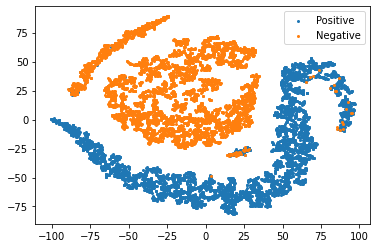

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def TSNE_extracted():
    
    pos=extracted_df[extracted_df.iloc[:,-1]==1]
    neg=extracted_df[extracted_df.iloc[:,-1]==0]
    X_feat=pd.concat([pos,neg])
    X_feat=X_feat.iloc[:,:-1]
    t=TSNE(n_components=2).fit_transform(X_feat)
    pos_t=t[:int(len(t)/2),:]
    neg_t=t[int(len(t)/2):,:]
    plt.scatter(pos_t[:,0],pos_t[:,1],label="Positive",s=4)
    plt.scatter(neg_t[:,0],neg_t[:,1],label="Negative",s=4)
    plt.legend()
    plt.show()

TSNE_extracted()

### Tensorboard monitor

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=/content/logs